In [1]:
%matplotlib inline
from xyzpy import *
import numpy as np

In [2]:
def foo(a, b, c):
    return a, b, c

and ``combos`` of the form:

In [3]:
combos = [
    ('a', [1, 2, 3]),
    ('b', ['x', 'y', 'z']),
    ('c', [True, False]),
]

and generates a nested (here 3 dimensional) array of all the outputs of ``foo`` with the ``3 * 3 * 2 = 18`` combinations of input arguments:

In [4]:
combo_runner(foo, combos)

100%|##########| 18/18 [00:00<00:00, 18083.23it/s]


((((1, 'x', True), (1, 'x', False)),
  ((1, 'y', True), (1, 'y', False)),
  ((1, 'z', True), (1, 'z', False))),
 (((2, 'x', True), (2, 'x', False)),
  ((2, 'y', True), (2, 'y', False)),
  ((2, 'z', True), (2, 'z', False))),
 (((3, 'x', True), (3, 'x', False)),
  ((3, 'y', True), (3, 'y', False)),
  ((3, 'z', True), (3, 'z', False))))

In [5]:
cases = [(4, 'z', False), (5, 'y', True)]
case_runner(foo, fn_args=('a', 'b', 'c'), cases=cases)

100%|##########| 2/2 [00:00<00:00, 471.93it/s]


((4, 'z', False), (5, 'y', True))

In [6]:
runner = Runner(foo, var_names=['a_out', 'b_out', 'c_out'])
runner.run_combos(combos)

100%|##########| 18/18 [00:00<00:00, 21024.08it/s]


<xarray.Dataset>
Dimensions:  (a: 3, b: 3, c: 2)
Coordinates:
  * a        (a) int64 1 2 3
  * b        (b) <U1 'x' 'y' 'z'
  * c        (c) bool True False
Data variables:
    a_out    (a, b, c) int64 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3
    b_out    (a, b, c) <U1 'x' 'x' 'y' 'y' 'z' 'z' ... 'x' 'x' 'y' 'y' 'z' 'z'
    c_out    (a, b, c) bool True False True False True ... True False True False

In [7]:
var_names = ['A', 'B', 'C']
var_dims = {'B': ['x'], 'C': ['x', 't']}
var_coords = {'x': [10, 20, 30]}
constants = {'t': np.linspace(0, 1, 101)}

In [8]:
def bar(i, j, k, t):
    A = np.random.rand()
    B = np.random.rand(3)  # 'B[x]'
    C = np.random.rand(3, len(t))  # 'C[x, t]'
    return A, B, C

# if we are using a runner, combos can be supplied as a dict
combos = {
    'i': [5, 6, 7],
    'j': [0.5, 0.6, 0.7],
    'k': [0.05, 0.06, 0.07],
}

We can then run the combos:

In [9]:
r = Runner(bar, constants=constants,
           var_names=var_names,
           var_coords=var_coords,
           var_dims=var_dims)
r.run_combos(combos)

100%|##########| 27/27 [00:00<00:00, 3709.71it/s]


<xarray.Dataset>
Dimensions:  (i: 3, j: 3, k: 3, t: 101, x: 3)
Coordinates:
  * i        (i) int64 5 6 7
  * j        (j) float64 0.5 0.6 0.7
  * k        (k) float64 0.05 0.06 0.07
  * x        (x) int64 10 20 30
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 0.96 0.97 0.98 0.99 1.0
Data variables:
    A        (i, j, k) float64 0.2533 0.4152 0.2226 ... 0.5986 0.7464 0.7801
    B        (i, j, k, x) float64 0.7641 0.2731 0.3556 ... 0.9066 0.2976 0.1442
    C        (i, j, k, x, t) float64 0.7664 0.4964 0.08095 ... 0.281 0.8488

In [10]:
combos = [
    ('a', [1, 2, 3]),
    ('b', ['x', 'y', 'z']),
    ('c', [True, False]),
]

harvester = Harvester(runner, data_name='foo.h5')
harvester.harvest_combos(combos)

100%|##########| 18/18 [00:00<00:00, 13503.39it/s]


Which, because it didn't exist yet, created the file ``data_name``:

In [11]:
ls *.h5

foo.h5*


In [12]:
combos2 = {
    'a': [4, 5, 6],
    'b': ['w', 'v'],
    'c': [True, False],
}
harvester.harvest_combos(combos2)

100%|##########| 12/12 [00:00<00:00, 1345.23it/s]


Now we can check the total dataset containing all combos and cases run so far:

In [13]:
harvester.full_ds

<xarray.Dataset>
Dimensions:  (a: 6, b: 5, c: 2)
Coordinates:
  * a        (a) int64 1 2 3 4 5 6
  * b        (b) object 'v' 'w' 'x' 'y' 'z'
  * c        (c) bool True False
Data variables:
    a_out    (a, b, c) float64 nan nan nan nan 1.0 1.0 ... nan nan nan nan nan
    b_out    (a, b, c) object nan nan nan nan 'x' 'x' ... nan nan nan nan nan
    c_out    (a, b, c) float64 nan nan nan nan 1.0 0.0 ... nan nan nan nan nan

In [14]:
import math
import random

@label(var_names=['out'])
def trig(amp, fn, x, phase):
    return amp * getattr(math, fn)(x - phase)

# these are the default combos/distributions to sample from
default_combos = {
    'amp': [1, 2, 3],
    'fn': ['cos', 'sin'],
    # for distributions we can supply callables
    'x': lambda: 2 * math.pi * random.random(),
    'phase': lambda: random.gauss(0.0, 0.1),
}

sampler = Sampler(trig, 'trig.pkl', default_combos)
sampler

<xyzpy.Sampler>
Runner: <xyzpy.Runner>
    fn: <function trig at 0x7f08fbd1e6a8>
    fn_args: ('amp', 'fn', 'x', 'phase')
    var_names: ('out',)
    var_dims: {'out': ()}
Sync file -->
    trig.pkl    [pickle]

Now we can run the sampler many times (and supply any of the usual arguments such as ``parallel=True`` etc). This generates a ``pandas.DataFrame``:

In [15]:
sampler.sample_combos(10000);

100%|##########| 10000/10000 [00:00<00:00, 37195.81it/s]


This has also synced the data with the on-disk file:

In [16]:
!ls *.pkl

trig.pkl


You can specify ``Sampler(..., engine='csv')`` etc to use formats other than ``pickle``.

As with the ``Harvester``, next time we run combinations, the data is automatically
aggregated into the full set:

In [17]:
# here we will override some of the default sampling choices
combos = {
    'fn': ['tan'],
    'x': lambda: random.random() * math.pi / 4
}

sampler.sample_combos(5000, combos);

100%|##########| 5000/5000 [00:00<00:00, 64517.83it/s]


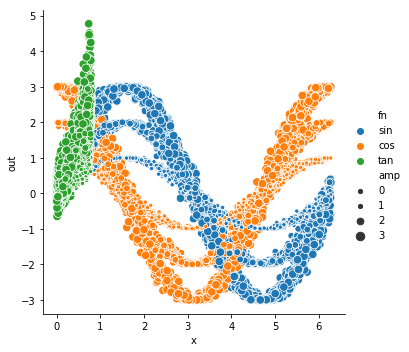

In [18]:
import seaborn as sns

sns.relplot(x='x', y='out', hue='fn', size='amp', data=sampler.full_df)

In [19]:
# some cleanup
harvester.delete_ds()
sampler.delete_df()